# 1. Install Dependencies and Setup

In [2]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [4]:
# !pip list

In [1]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [5]:
import cv2
import imghdr

In [6]:
data_dir = 'data'

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [23]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 2588 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [20]:
batch = data_iterator.next()

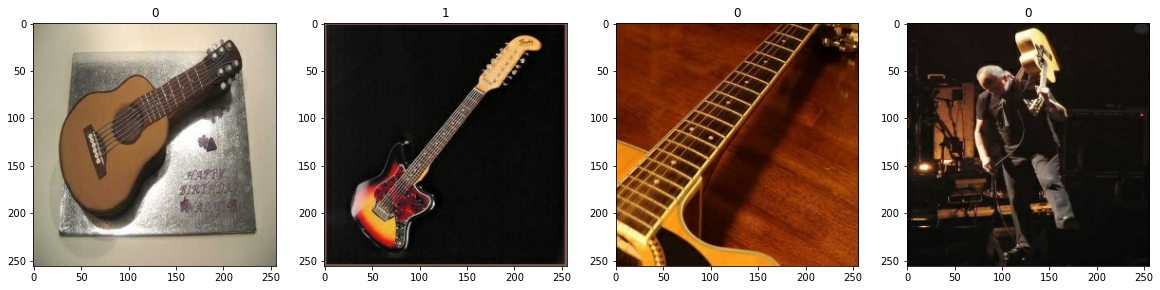

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [22]:
len(data)

81

In [24]:
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [27]:
# data.as_numpy_iterator().next()

# 5. Split Data

In [25]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [26]:
len(data)

81

In [27]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [28]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [30]:
model = Sequential()

In [31]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [32]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [34]:
logdir='logs'

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [36]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
56/56 [==============================] - 18s 310ms/step - loss: 0.7059 - accuracy: 0.5536 - val_loss: 0.6848 - val_accuracy: 0.6230
Epoch 2/20
56/56 [==============================] - 18s 313ms/step - loss: 0.6598 - accuracy: 0.6445 - val_loss: 0.6439 - val_accuracy: 0.6426
Epoch 3/20
56/56 [==============================] - 18s 320ms/step - loss: 0.6131 - accuracy: 0.6892 - val_loss: 0.6105 - val_accuracy: 0.6660
Epoch 4/20
56/56 [==============================] - 18s 316ms/step - loss: 0.5009 - accuracy: 0.7595 - val_loss: 0.6659 - val_accuracy: 0.6758
Epoch 5/20
56/56 [==============================] - 18s 316ms/step - loss: 0.3756 - accuracy: 0.8359 - val_loss: 0.7778 - val_accuracy: 0.6855
Epoch 6/20
56/56 [==============================] - 19s 329ms/step - loss: 0.3281 - accuracy: 0.8527 - val_loss: 0.8254 - val_accuracy: 0.6758
Epoch 7/20
56/56 [==============================] - 18s 318ms/step - loss: 0.1923 - accuracy: 0.9314 - val_loss: 0.8416 - val_accuracy: 0.7148

# 8. Plot Performance

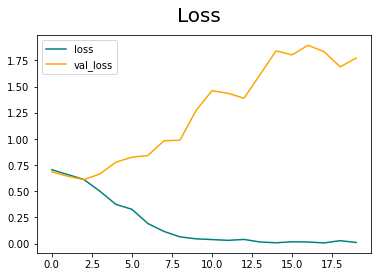

In [37]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

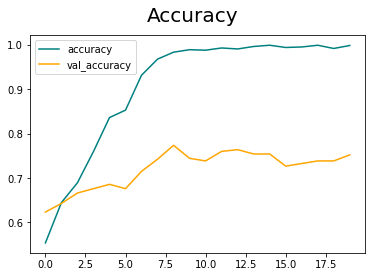

In [38]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [39]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [40]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [41]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 61ms/step


In [42]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.6118420958518982, Recall: 0.7153846025466919, Accuracy: 0.625


# 10. Test

In [43]:
import cv2

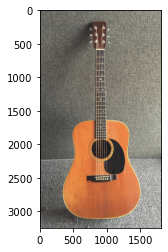

In [44]:
img = cv2.imread('guitar.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

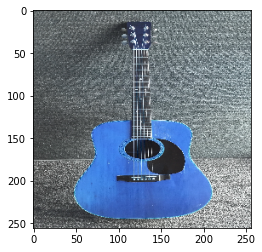

In [45]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [46]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 73ms/step


In [47]:
yhat

array([[8.191235e-06]], dtype=float32)

In [48]:
if yhat > 0.5: 
    print(f'Predicted class is Electric Guitar')
else:
    print(f'Predicted class is Acoustic Guitar')

Predicted class is Acoustic Guitar


# 11. Save the Model

In [49]:
from tensorflow.keras.models import load_model

In [50]:
model.save(os.path.join('models','guitarclassifier.h5'))

In [87]:
new_model = load_model(os.path.join('models','guitarclassifier.h5'))

In [92]:
preds=new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 16ms/step


In [95]:
if preds > 0.5: 
    print(f'Electric Guitar')
else:
    print(f'Acoustic Guitar')

Acoustic Guitar
